# Subspace EKF

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from rebayes.low_rank_filter import subspace_filter
from functools import partial

/home/gerardoduran/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-10 05:58:24.229750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import tensorflow_datasets as tfds

def process_dataset(Xtr, Ytr, Xval, Yval, Xte, Yte, shuffle=False, oh_train=True, key=0):
    if isinstance(key, int):
        key = jax.random.PRNGKey(key)
        
    # Reshape data
    Xtr = Xtr.reshape(-1, 1, 28, 28, 1)
    if oh_train:
        Ytr = jax.nn.one_hot(Ytr, 10) # one-hot encode labels
    
    # Shuffle data
    if shuffle:
        idx = jax.random.permutation(key, jnp.arange(len(Xtr)))
        Xtr, Ytr = Xtr[idx], Ytr[idx]
    
    Xtr, Ytr, Xval, Yval, Xte, Yte = (jnp.array(data) for data in [Xtr, Ytr, Xval, Yval, Xte, Yte])
    
    dataset = {
        'train':[jnp.array(d) for d in (Xtr, Ytr)],
        'val': [jnp.array(d) for d in (Xval, Yval)],
        'test': [jnp.array(d) for d in (Xte, Yte)],
    }
    
    return dataset


def load_mnist_dataset(fashion=False, n_train=None, n_val=None, n_test=None):
    """Load MNIST train and test datasets into memory."""
    dataset='mnist'
    if fashion:
        dataset='fashion_mnist'
    ds_builder = tfds.builder(dataset)
    ds_builder.download_and_prepare()
    
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[10%:]', batch_size=-1))
    val_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:10%]', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    
    # Normalize pixel values
    for ds in [train_ds, val_ds, test_ds]:
        ds['image'] = np.float32(ds['image']) / 255.
    
    n_train = min(n_train, len(train_ds['image'])) if n_train else len(train_ds['image'])
    n_val = min(n_val, len(val_ds['image'])) if n_val else len(val_ds['image'])
    n_test = min(n_test, len(test_ds['image'])) if n_test else len(test_ds['image'])
    
    X_train, y_train = (jnp.array(train_ds[key][:n_train]) for key in ['image', 'label'])
    X_val, y_val = (jnp.array(val_ds[key][:n_val]) for key in ['image', 'label'])
    X_test, y_test = (jnp.array(test_ds[key][:n_test]) for key in ['image', 'label'])
    
    dataset = process_dataset(X_train, y_train, X_val, y_val, X_test, y_test, shuffle=True)
        
    return dataset

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from typing import Callable

In [6]:
class NNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10, name="gets_cov")(x)
        x = nn.elu(x)
        x = nn.Dense(10)(x)
        x = nn.elu(x)
        x = nn.Dense(1)(x)
        return x

In [7]:
key = jax.random.PRNGKey(314)

model = NNet()
n_features = 2
Xinit = jnp.ones((10, n_features))
dim_subspace = 10
params_init = model.init(key, Xinit)
params_flat, rfn = ravel_pytree(params_init)
dim_full = len(params_flat)

pmatrix = jax.random.bernoulli(key, p=0.5, shape=(dim_full, dim_subspace))
params_latent = jax.random.normal(key, shape=(dim_subspace,))

In [8]:
params_latent

Array([-1.4314531 , -1.4140283 ,  0.5512039 , -0.33057716, -0.39858606,
        0.6754447 , -0.08324226, -0.3476744 ,  0.34246936, -0.03261461],      dtype=float32)

In [9]:
NNet().apply(params_init, Xinit).ravel()

Array([2.5442393, 2.5442393, 2.5442393, 2.5442393, 2.5442393, 2.5442393,
       2.5442393, 2.5442393, 2.5442393, 2.5442393], dtype=float32)

## Subspace agent

See [this issue](https://github.com/deepmind/optax/discussions/167) for implementation

In [10]:
import optax

In [11]:
def subcify(cls):
    class SubspaceModule(nn.Module):
        dim_in: int
        dim_subspace: int
        init_normal: Callable = nn.initializers.normal()
        init_proj: Callable = nn.initializers.normal()


        def init(self, rngs, *args, **kwargs):
            # TODO: Add case 
            r1, r2 = jax.random.split(rngs, 2)
            rngs_dict = {"params": r1, "fixed": r2}
            
            return nn.Module.init(self, rngs_dict, *args, **kwargs)

        def setup(self):

            key_dummy = jax.random.PRNGKey(0)
            params = cls().init(key_dummy, jnp.ones((1, self.dim_in)))
            params_all, reconstruct_fn = ravel_pytree(params)
            
            self.dim_full = len(params_all)
            self.reconstruct_fn = reconstruct_fn
            
            self.subspace = self.param(
                "subspace",
                self.init_proj,
                (self.dim_subspace,)
            )

            shape = (self.dim_full, self.dim_subspace)
            init_fn = lambda shape: self.init_proj(self.make_rng("fixed"), shape)
            self.projection = self.variable("fixed", "P", init_fn, shape).value

            shape = (self.dim_full,)
            init_fn = lambda shape: self.init_proj(self.make_rng("fixed"), shape)
            self.bias = self.variable("fixed", "b", init_fn, shape).value

        @nn.compact
        def __call__(self, x):
            params = self.projection @ self.subspace  + self.bias
            params = self.reconstruct_fn(params)
            return cls().apply(params, x)
    
    return SubspaceModule

In [12]:
@subcify
class SubNNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.elu(x)
        x = nn.Dense(10)(x)
        x = nn.elu(x)
        x = nn.Dense(1)(x)
        return x

In [13]:
key = jax.random.PRNGKey(314)
dim_in = 2
Xinit = jnp.ones((1, dim_in))
model = SubNNet(dim_in, dim_subspace=5)
params_init = model.init(key, Xinit)
# params_init

jax.tree_map(jnp.shape, params_init)

FrozenDict({
    fixed: {
        P: (151, 5),
        b: (151,),
    },
    params: {
        subspace: (5,),
    },
})

## MNSIT dataset

In [17]:
dataset = load_mnist_dataset()

In [18]:
X, y = dataset["train"]

In [19]:
X = X.reshape(-1, 28 ** 2)
y.shape

(54000, 10)

In [20]:
@subcify
class SubNNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = nn.elu(x)
        x = nn.Dense(500)(x)
        x = nn.elu(x)
        x = nn.Dense(200)(x)
        x = nn.elu(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [38]:
key = jax.random.PRNGKey(314)
dim_in = 28 ** 2
Xinit = jnp.ones((1, dim_in))
model = SubNNet(dim_in, dim_subspace=50)
params_init = model.init(key, Xinit)
pfixed, psubspace_init = params_init["fixed"], params_init["params"]
# params_init

jax.tree_map(jnp.shape, params_init)

FrozenDict({
    fixed: {
        P: (745210, 50),
        b: (745210,),
    },
    params: {
        subspace: (50,),
    },
})

In [39]:
def applyfn(psubspace, X):
    pfull = {
        "fixed": pfixed,
        "params": psubspace
    }
    return model.apply(pfull, X)

In [47]:
def lossfn(params, X, y):
    nsamples = len(X)
    log_yhat = jnp.log(applyfn(params, X))
    loss = -jnp.einsum("nk,nk", y, log_yhat) / nsamples
    return loss

In [64]:
tx = optax.adam(5e-4)
state = TrainState.create(apply_fn=applyfn,
                          params=psubspace_init,
                          tx=tx)

val_nabla_loss = jax.jit(jax.value_and_grad(lossfn))

losses = []
for _ in tqdm(range(5000)):
    l, grads = val_nabla_loss(state.params, X[:400], y[:400])
    state = state.apply_gradients(grads=grads)
    losses.append(l)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 156.69it/s]


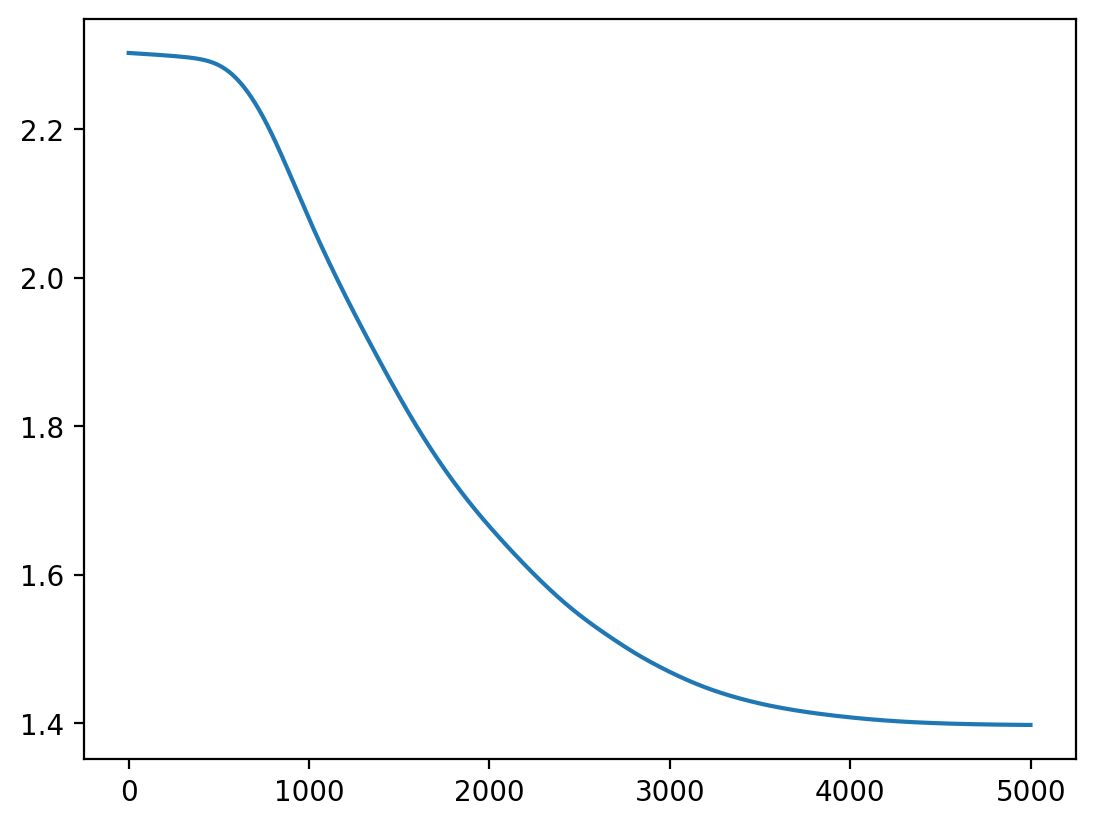

In [65]:
plt.plot(losses)

In [66]:
(applyfn(state.params, X[:400]).argmax(axis=1) == y[:400].argmax(axis=1)).mean()

Array(0.56, dtype=float32)